In [2]:
import pandas as pd
import numpy as np
import datetime as dt

# Load original data
df = pd.read_csv('../data/raw/2019-Nov.csv')

# Convert event_time to datetime
df['event_time'] = pd.to_datetime(df['event_time'])

# Filter only purchase events
purchase_df = df[df['event_type'] == 'purchase'].copy()


In [3]:
# Reference date = one day after last purchase in data
reference_date = purchase_df['event_time'].max() + pd.Timedelta(days=1)

# Group by user
rfm = purchase_df.groupby('user_id').agg({
    'event_time': lambda x: (reference_date - x.max()).days,  # Recency
    'user_session': 'nunique',                               # Frequency (unique sessions)
    'price': 'sum'                                            # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['user_id', 'Recency', 'Frequency', 'Monetary']

# Check the result
rfm.head()


,user_id,Recency,Frequency,Monetary
0,138340325,20,1,93.50
1,225644257,19,1,40.91
2,253299396,25,1,246.85
3,256164170,11,1,113.23
4,267316896,17,1,189.71


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


In [6]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Segment'] = kmeans.fit_predict(rfm_scaled)


In [7]:
# Segment behavior summary
rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'user_id': 'count'
}).rename(columns={'user_id': 'Customer Count'})


,Recency,Frequency,Monetary,Customer Count
Segment,,,,
0,9.932603,1.556218,485.120620,289462
1,4.492424,32.600379,28763.143636,528
2,23.447921,1.279684,372.647427,136254
3,7.176173,8.521047,4469.875483,15394


In [15]:
segment_summary = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'user_id': 'count'
}).rename(columns={'user_id': 'Customer_Count'}).round(2)

segment_summary


,Recency,Frequency,Monetary,Customer_Count
Segment,,,,
0,9.93,1.56,485.12,289462
1,4.49,32.60,28763.14,528
2,23.45,1.28,372.65,136254
3,7.18,8.52,4469.88,15394


In [17]:
# Example mapping (adjust based on your summary)
segment_map = {
    0: 'At-Risk',
    1: 'High-Value Loyalists',
    2: 'One-Time Buyers',
    3: 'Engaged Regulars'
}

rfm['Segment_Label'] = rfm['Segment'].map(segment_map)


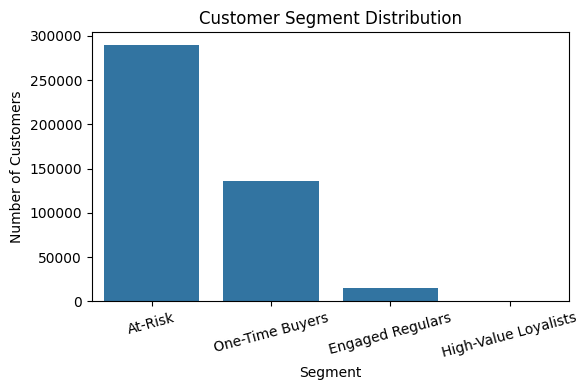

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x='Segment_Label', data=rfm, order=rfm['Segment_Label'].value_counts().index)
plt.title('Customer Segment Distribution')
plt.xticks(rotation=15)
plt.ylabel('Number of Customers')
plt.xlabel('Segment')
plt.tight_layout()
plt.show()


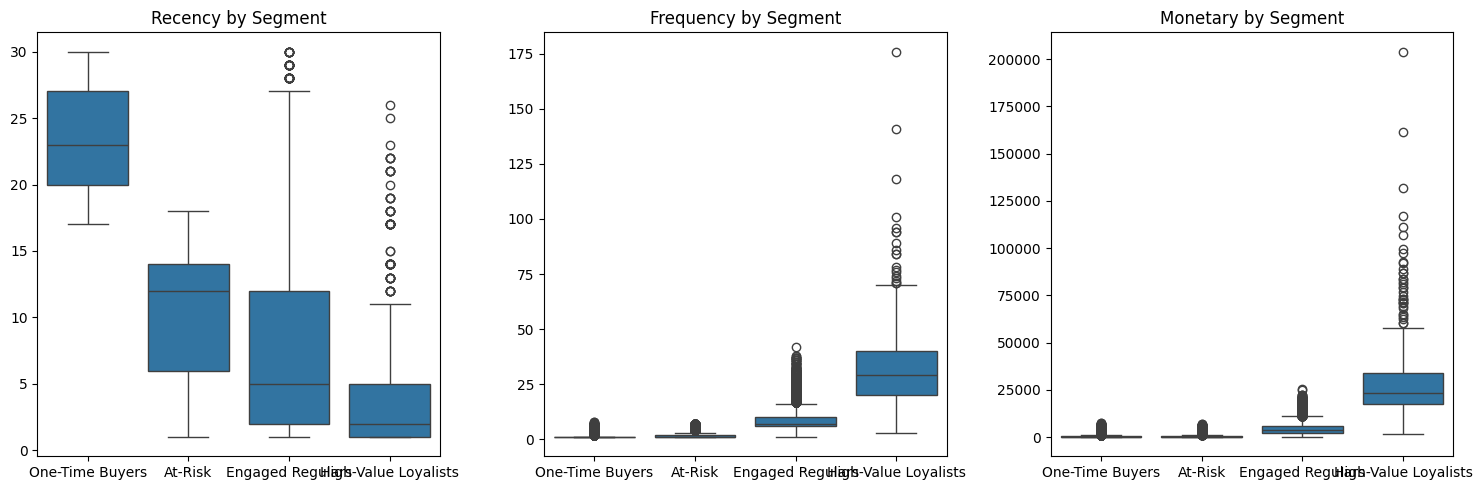

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(data=rfm, x='Segment_Label', y='Recency', ax=axes[0])
sns.boxplot(data=rfm, x='Segment_Label', y='Frequency', ax=axes[1])
sns.boxplot(data=rfm, x='Segment_Label', y='Monetary', ax=axes[2])

axes[0].set_title('Recency by Segment')
axes[1].set_title('Frequency by Segment')
axes[2].set_title('Monetary by Segment')

for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()


In [20]:
rfm.to_csv('../data/processed/rfm_segments.csv', index=False)
